
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [15]:
from __future__ import division

import warnings


from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
from scipy import stats

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [16]:
import chart_studio
chart_studio.tools.set_credentials_file(username='ffftelias', api_key='••••••••••')

import chart_studio.plotly as py
import plotly.graph_objects as go

In [3]:
warnings.filterwarnings("ignore")

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

import ruptures as rpt

In [5]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.6f}'.format

# Función Productividad de pozos

In [8]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    global vector
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                               'expon',
                               'gamma',
                               'lognorm',
                               'norm',
                               'pearson3',
                               'triang',
                               'uniform',
                               'weibull_min', 
                               'weibull_max',
                               'alpha',             
                               'anglit',            
                               'arcsine',           
                               'argus',                       
                               'betaprime',         
                               'bradford',          
                               'burr',              
                               'burr12',            
                               'cauchy',            
                               'chi',               
                               'chi2',              
                               'cosine',            
                               'crystalball',       
                               'dgamma',            
                               'dweibull',          
                               'erlang',            
                               'exponnorm',         
                               'exponweib',         
                               'exponpow',          
                               'f',                 
                               'fatiguelife',       
                               'fisk',              
                               'foldcauchy',        
                               'foldnorm',          
                               'frechet_r',         
                               'frechet_l',         
                               'genlogistic',       
                               'gennorm',           
                               'genpareto',         
                               'genexpon',          
                               'genextreme',        
                               'gausshyper',             
                               'gengamma',          
                               'genhalflogistic',   
                               'gilbrat',           
                               'gompertz',          
                               'gumbel_r',          
                               'gumbel_l',          
                               'halfcauchy',        
                               'halflogistic',      
                               'halfnorm',          
                               'halfgennorm',       
                               'hypsecant',         
                               'invgamma',          
                               'invgauss',          
                               'invweibull',        
                               'johnsonsb',         
                               'johnsonsu',         
                               'kappa4',            
                               'kappa3',            
                               'ksone',             
                               'kstwobign',         
                               'laplace',           
                               'levy',              
                               'levy_l',
                               'levy_stable',
                               'logistic',          
                               'loggamma',          
                               'loglaplace',                  
                               'lomax',             
                               'maxwell',           
                               'mielke',            
                               'moyal',             
                               'nakagami',          
                               'ncx2',              
                               'ncf',               
                               'nct',                
                               'norminvgauss',      
                               'pareto',          
                               'powerlaw',          
                               'powerlognorm',      
                               'powernorm',         
                               'rdist',             
                               'reciprocal',        
                               'rayleigh',          
                               'rice',              
                               'recipinvgauss',     
                               'semicircular',      
                               'skewnorm',          
                               't',                 
                               'trapz',                        
                               'truncexpon',        
                               'truncnorm',         
                               'tukeylambda',           
                               'vonmises',          
                               'vonmises_line',     
                               'wald',       
                               'wrapcauchy']
            
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                         #index_col=1,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    vector=pd.DataFrame()
    gasto=pd.DataFrame()
    
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 24, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        production_time_series.loc[:,'month']=(production_time_series['aceite_Mbd'] > 0).cumsum()
        
        gasto=[[pozo,qi]]
        display(gasto)

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='month'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
        vector=vector.append(gasto,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    vector=vector.rename(columns={0:'pozo',1:'qi'}).set_index('pozo')
    vector.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    #results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.month,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('month')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

# Productividad 2

In [18]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    global vector
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                               'expon',
                               'gamma',
                               'lognorm',
                               'norm',
                               'pearson3',
                               'triang',
                               'uniform',
                               'weibull_min', 
                               'weibull_max']
            
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                         #index_col=1,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    vector=pd.DataFrame()
    gasto=pd.DataFrame()
    
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 24, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        production_time_series.loc[:,'month']=(production_time_series['aceite_Mbd'] > 0).cumsum()
        
        gasto=[[pozo,qi]]
        display(gasto)

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='month'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
        vector=vector.append(gasto,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    vector=vector.rename(columns={0:'pozo',1:'qi'}).set_index('pozo')
    vector.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    #results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.month,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('month')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

'Numero de datos en BD: 2851710'

Nombre de Campo: SIHIL


'Numero de datos para SIHIL: 2210'

'Número de pozos en SIHIL: 28'

array(['SIHIL-19', 'SIHIL-18', 'SIHIL-14', 'SIHIL-1', 'SIHIL-2',
       'SIHIL-3', 'SIHIL-10', 'SIHIL-9', 'SIHIL-6', 'SIHIL-11', 'SIHIL-8',
       'SIHIL-13', 'SIHIL-4', 'SIHIL-7', 'SIHIL-23', 'SIHIL-12',
       'SIHIL-21', 'SIHIL-5', 'SIHIL-16', 'SIHIL-15', 'SIHIL-24',
       'SIHIL-28', 'SIHIL-22', 'SIHIL-17', 'SIHIL-25', 'SIHIL-29',
       'SIHIL-20', 'SIHIL-27'], dtype=object)

'Percentiles y estadistica descriptiva: '

0.100000   0.349376
0.500000   1.684552
0.900000   8.764834
Name: aceite_Mbd, dtype: float64

,Unnamed: 0,aceite_Mbd,agua_Mbd,condensado_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,ano_perforacion,GID,profundidad_total,profundidad_vertical
count,"2,208.000000","2,208.000000","2,208.000000","2,208.000000","2,208.000000","2,208.000000","2,210.000000","2,210.000000","2,209.000000","2,159.000000"
mean,"597,882.991395",3.130850,0.959443,0.000000,1.401005,0.000000,"2,009.349774","239,521.776471","3,873.565867","3,611.148263"
std,"69,434.367641",3.558107,1.458592,0.000000,1.763168,0.000000,2.795637,"2,225.757918",263.065196,267.011530
min,"399,979.000000",0.000000,0.000000,0.000000,0.000000,0.000000,"2,003.000000","235,375.000000","2,163.000000","2,023.000000"
25%,"548,422.750000",0.754595,0.024888,0.000000,0.305690,0.000000,"2,009.000000","237,925.000000","3,660.000000","3,472.000000"
50%,"598,382.500000",1.684552,0.315121,0.000000,0.730102,0.000000,"2,010.000000","239,635.000000","3,825.000000","3,529.200000"
75%,"654,198.250000",3.966087,1.305503,0.000000,1.969650,0.000000,"2,011.000000","240,985.000000","4,050.000000","3,654.000000"
max,"714,198.000000",18.236045,14.315306,0.000000,19.681500,0.000000,"2,014.000000","246,218.000000","4,385.000000","4,353.000000"


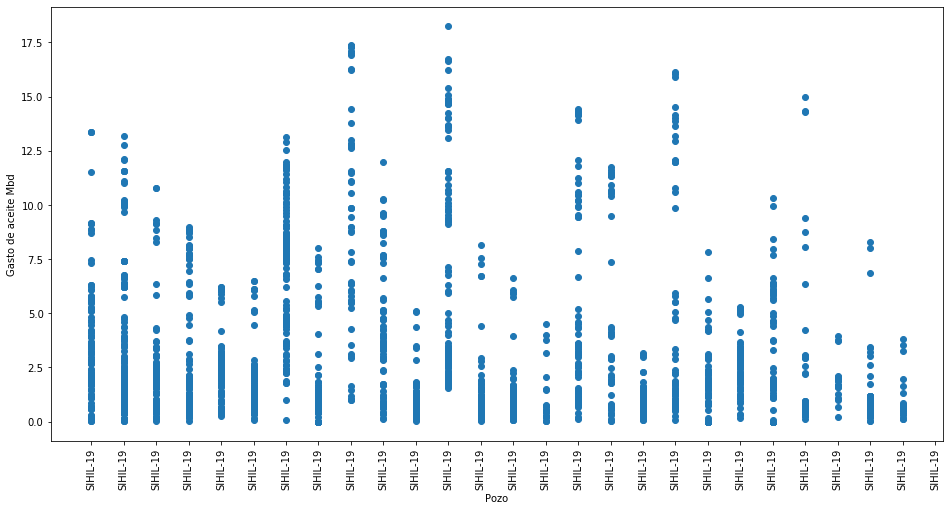

RuntimeError: 

In [19]:
productividad()

In [ ]:
periodo=np.arange(start=1,stop=201,step=1)
fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=200,normalize=True,closed='left')

df=pd.DataFrame()

df['date']=fechas
df['month']=pd.DatetimeIndex(fechas).month
df['year']=pd.DatetimeIndex(fechas).year
df['days']=pd.DatetimeIndex(fechas).day
df['periodo']=periodo

display(df.head())

In [46]:
resultado=pd.DataFrame()
gasto=pd.DataFrame()

q10=vector.qi.quantile(.1)
q50=vector.qi.quantile(.5)
q90=vector.qi.quantile(.9)

for x in df:
    p10=(q10/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    p50=(q50/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    p90=(q90/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    
    gasto=[[x,p10,p50,p90]]

NameError: name 'gasto_' is not defined

In [ ]:
#resultado=resultado.append(gasto,sort=True)

#display(resultado)

#resultado=resultado.rename(columns={0:'mes',
 #                                   1:'p10',
  #                                  2:'p50',
   #                                 3:'p90',}).set_index('mes')

gasto.plot(figsize=(15,12))

precio_aceite=50

ingresos=pd.DataFrame()
for x in resultado:
    ingresos['p50']=precio_aceite*resultado['p50']



display(ingresos)

In [68]:
oil=results[['pozo','aceite_Mbd','month']]

df2=oil.groupby('month').mean().reset_index()

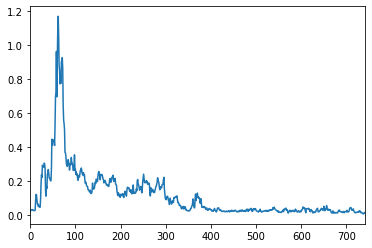

In [30]:
df2.aceite_Mbd.plot()

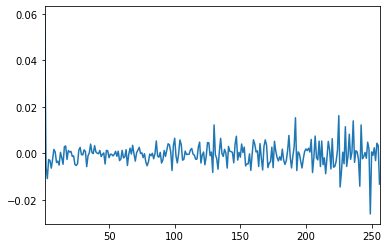

In [10]:
#create a new dataframe to model the difference
df_diff = df2.copy()

#add previous sales to the next row
df_diff['prev_Qo'] = df_diff['aceite_Mbd'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['aceite_Mbd'] - df_diff['prev_Qo']) 
df_diff['diff'].plot()

In [11]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_Qo'],axis=1)
#adding lags
for inc in range(1,51):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [12]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+'
                                +'lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+'
                                +'lag_13+lag_14+lag_15+lag_16+lag_17+'
                                +'lag_18+lag_19+lag_20+lag_21+lag_22+'
                                +'lag_23+lag_24+lag_25+lag_26+lag_27+'
                                +'lag_28+lag_29+lag_30+lag_31+lag_32+'
                                +'lag_33+lag_34+lag_35+lag_36+lag_37+'
                                +'lag_38+lag_39+lag_40+lag_41+lag_42+'
                                +'lag_43+lag_44+lag_45+lag_46+lag_47+'
                                +'lag_48+lag_49+lag_50',
                                data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.24776198135994965


In [13]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['aceite_Mbd','month'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-25].values, df_model[-25:].values

In [14]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [15]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [16]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1070
Epoch 2/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0667
Epoch 3/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0602
Epoch 4/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0563
Epoch 5/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0530
Epoch 6/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0497
Epoch 7/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0461
Epoch 8/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0422
Epoch 9/100
181/181 [==============================] - 1s 3ms/step - loss: 0.0381
Epoch 10/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0339
Epoch 11/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0298
Epoch 12/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0262
Epoch 13/100


181/181 [==============================] - ETA: 0s - loss: 0.001 - 1s 4ms/step - loss: 0.0016
Epoch 100/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0020


In [17]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [18]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.21794733 -0.4228782   0.68908224 -0.34825003 -0.02404854 -0.57760799
  -1.45839458  1.0761831  -0.15298126 -0.55192058 -0.7383236  -0.76711757
   0.25063239 -0.82831343 -0.14979774  0.15378574 -0.4045341  -1.0424284
  -0.46284652 -0.7152224   0.15013477 -0.78047566  0.14652    -0.5381905
  -0.46314362  0.33170402 -0.45810384 -1.00421792  0.20734798 -0.25531075
  -0.11635897 -0.20302868 -0.13983775 -0.23205418 -0.49021017 -0.83737784
  -0.59671167 -0.31961746 -0.24772804 -0.93137437  1.30218462  0.08691309
  -0.32083119 -0.81290777 -0.349914    0.55719151 -0.09270171 -0.50687209
  -0.47364807 -0.3179462  -0.63786262]]
[[ 0.60302114 -0.13861405 -0.4228782   0.68908224 -0.34825003 -0.02404854
  -0.93919147 -1.47585554  1.0761831  -0.15298126 -0.55192058 -0.7383236
  -0.76711757  0.25063239 -0.82831343 -0.14979774  0.15378574 -0.43433017
  -1.0424284  -0.46284652 -0.7152224   0.15013477 -0.78047566  0.14652
  -0.5381905  -0.46314362  0.33170402 -0.46117892 -1.00421792  0.20734798
  -0

In [19]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df2[50:].month)
#display(sales_dates)
act_sales = list(df2[50:].aceite_Mbd)
#display(act_sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['month'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales
#merge with actual sales dataframe
df_sales_pred = pd.merge(df2,df_result,on='month',how='left')

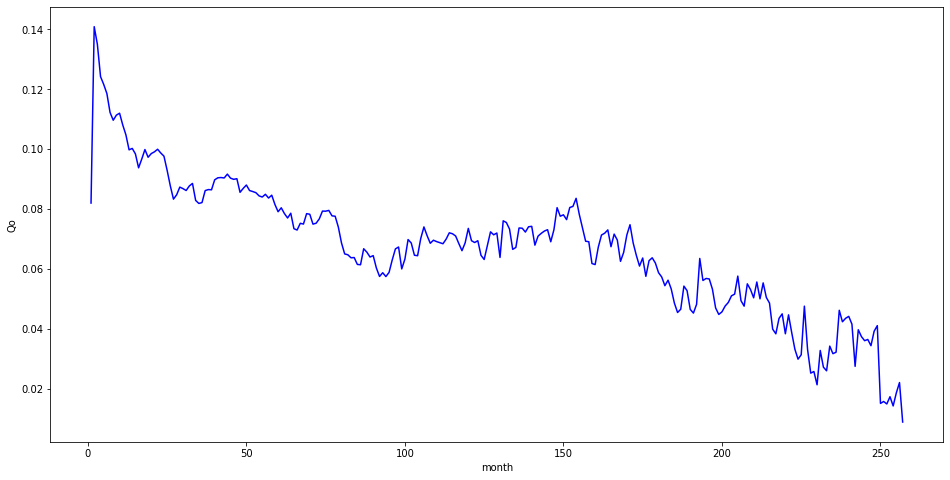

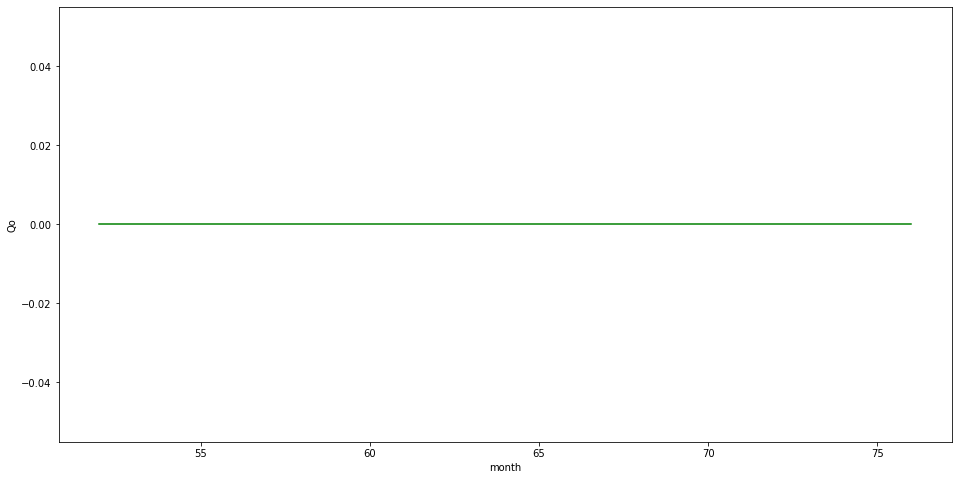

In [20]:
fig4, ax4 = plt.subplots(figsize=(16,8))
ax4.plot(df_sales_pred['month'],df_sales_pred['aceite_Mbd'],color='Blue')
ax4.set_xlabel('month')
ax4.set_ylabel('Qo')
plt.show()

fig5, ax5 = plt.subplots(figsize=(16,8))
ax5.plot(df_sales_pred['month'],df_sales_pred['pred_value'],color='Green')
ax5.set_xlabel('month')
ax5.set_ylabel('Qo')
plt.show()

Segmentar el df por dia de max produccion en adelante

# Change Point Detection

# Binary segmentation method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l2"  
        algo = rpt.Binseg(model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000_000)
        # show results
        rpt.show.display(points, my_bkps, figsize=(10, 6),scalex=False)
        plt.title('Change Point Detection: Binary Segmentation Search Method')
        plt.show()

# Pelt search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model="rbf"
        algo = rpt.Pelt(model=model).fit(points)
        result = algo.predict(pen=1_000)
        rpt.display(points, result, figsize=(10, 6))
        plt.title('Change Point Detection: Pelt Search Method')
        plt.show()

# Dynamic programming search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l1"  
        algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
        my_bkps = algo.predict(n_bkps=10)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Dynamic Programming Search Method')
        plt.show()

# Window-based search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)
        
        model = "l2"  
        algo = rpt.Window(width=40, model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Window-Based Search Method')
        plt.show()

In [ ]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    global z_score
    global outliers
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return z_score

In [ ]:
score=[]
def outlier_filter(data):
    global score
    global outliers
    threshold=3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    
    for y in data:
        z = (y - mean_1)/std_1 
        score.append(z)
    return score

In [ ]:
df=campo
outliers=outlier_filter(df.aceite_Mbd)


In [ ]:
display(score) 

In [36]:
display(fechas)

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               ...
               '2035-11-30', '2035-12-31', '2036-01-31', '2036-02-29', '2036-03-31', '2036-04-30', '2036-05-31', '2036-06-30', '2036-07-31', '2036-08-31'], dtype='datetime64[ns]', length=200, freq='M')

In [56]:
for mes in fechas:
    x=calendar.monthrange(mes[0],mes[1])
    display(x)

TypeError: 'Timestamp' object is not subscriptable

In [ ]:
mx_stats=pd.read_csv(r'C:\Users\elias\Downloads\Well_production/pozos.csv',
                         #index_col=1,
                         parse_dates=True,
                         #encoding='utf-8',
                         engine='python',
                         low_memory=True)

In [47]:
display(mx_stats.shape)

(2886837, 9)

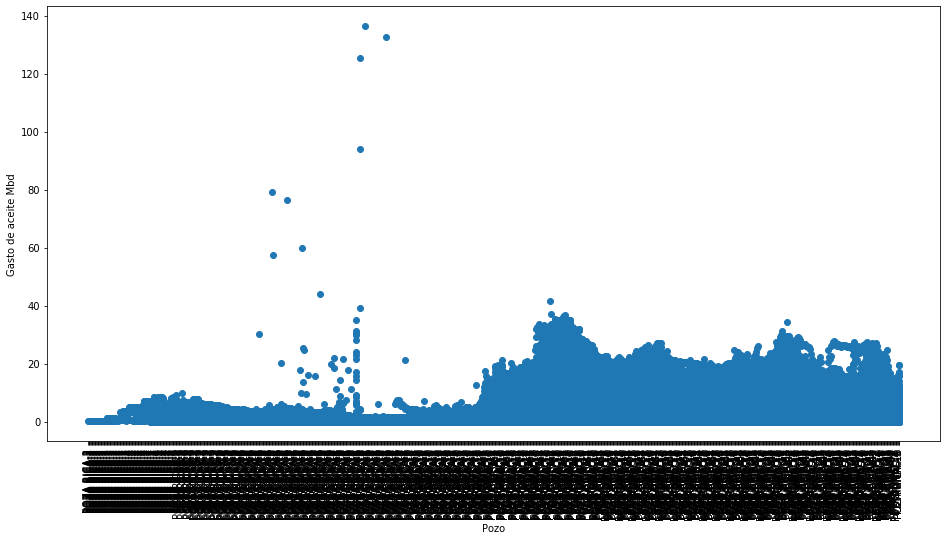

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(mx_stats.fecha,mx_stats.aceite_Mbd)
ax.set_xlabel('Pozo')
ax.set_xticklabels(labels=mx_stats.pozo,rotation=90)
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()